In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import regularizers
import time

In [2]:
df = pd.read_csv('C:/Users/shu_n/Downloads/carbonemissions_cleaned_2.csv')
df.head()

,Reported Scope 1 (tCO2e),Estimated Scope 1 (tCO2e),Scope 1 quality flag,Reported market-based Scope 2 (tCO2e),Reported location-based Scope 2 (tCO2e),Estimated location-based Scope 2 (tCO2e),Location-based Scope 2 quality flag,amplification.wordsindex,DeAmplification.wordsindex,HE_negativeindex,...,2016vol,2017vol,2018vol,2019vol,VolFactor,Carbon Emission (tCO2e/mmUSD),Listed_encoded,HQ Country_encoded,GICS Sector_encoded,Scope 2 figure used for intensity_encoded
0,0.00,1400.0,2.0,0.0,0.0,3000.0,3.0,0,0,0,...,0.023033,0.023079,0.033899,0.021700,0.178446,26.030882,1,0,2,0
1,933.37,0.0,7.0,0.0,27626.0,0.0,0.0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.968841,1,0,3,0
2,0.00,12000000.0,6.0,0.0,0.0,1200000.0,6.0,48,84,165,...,0.024063,0.021263,0.030650,0.029235,0.064662,926.111720,1,0,2,0
3,119338.00,0.0,7.0,0.0,169447.0,0.0,0.0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.908367,1,1,5,0
4,43258798.00,0.0,7.0,526294.7,526700.0,0.0,7.0,0,0,0,...,0.013876,0.012527,0.013894,0.013356,0.492732,5390.042347,1,1,10,1


In [4]:
X = df.drop(['Carbon Emission  (tCO2e/mmUSD)'], axis=1).values
Y = df['Carbon Emission  (tCO2e/mmUSD)'].values.reshape(X.shape[0], 1)
print(X.shape)
print(Y.shape)

(3920, 53)
(3920, 1)


In [5]:
# Matrix normalization:
def normalize(V):
    mean = np.mean(V, axis=0)
    stdev = np.std(V, axis=0)
    normalized = (V - mean) / stdev
    return normalized, mean, stdev

def inverse_norm(V, mean, stdev):
    return V * stdev + mean

X_norm, X_mean, X_std = normalize(X)
Y_norm, Y_mean, Y_std = normalize(Y)
print(Y_mean)
print(Y_std)

[ 330.77638977]
[ 749.59662901]


In [6]:
X_norm_train, X_norm_test_val, Y_norm_train, Y_norm_test_val = train_test_split(X_norm, Y_norm, test_size=0.4, random_state=1)
X_norm_val, X_norm_test, Y_norm_val, Y_norm_test = train_test_split(X_norm_test_val, Y_norm_test_val, test_size=0.5, random_state=1)
print(X_norm_train.shape)
print(Y_norm_train.shape)
print(X_norm_val.shape)
print(Y_norm_val.shape)

(2352, 53)
(2352, 1)
(784, 53)
(784, 1)


In [7]:
def root_mean_sq_error(Y,Y_hat):
    return np.sqrt(np.sum((Y - Y_hat) ** 2) / Y.shape[0])

def abs_mean_error(Y,Y_hat):
    return np.sum(np.abs((Y - Y_hat) / Y)) / Y.shape[0]

In [8]:
def train_model(model, epochs=1000):
    tic = time.time()
    hist = model.fit(X_norm_train, Y_norm_train, batch_size=X_norm_train.shape[0], epochs=epochs, shuffle=True, verbose=0)
    toc = time.time()
    print('Time :' + str(toc - tic))
    loss = hist.history['loss']
    print('Last loss: ' + str(loss[len(loss)-1]))
    plt.plot(loss)
    plt.show()

In [9]:
def model_pred(model):
    Y_hat_norm_train = model.predict(X_norm_train)
    Y_hat_norm_val = model.predict(X_norm_val)
    Y_hat_train = inverse_norm(Y_hat_norm_train,Y_mean,Y_std)
    Y_hat_val = inverse_norm(Y_hat_norm_val,Y_mean,Y_std)
    Y_train = inverse_norm(Y_norm_train,Y_mean,Y_std)
    Y_val = inverse_norm(Y_norm_val,Y_mean,Y_std)
    print('Training error 1: ' + str(root_mean_sq_error(Y_hat_train,Y_train)))
    print('Prediction error 1: ' + str(root_mean_sq_error(Y_hat_val,Y_val)))
    train_error = abs_mean_error(Y_hat_train,Y_train)
    test_error = abs_mean_error(Y_hat_val,Y_val)
    print('Training error 2: ' + str(train_error))
    print('Prediction error 2: ' + str(test_error))
    plt.scatter(Y_train, Y_hat_train)
    plt.show()
    plt.scatter(Y_val, Y_hat_val)
    plt.show()

In [10]:
# Model tuned in ce_deepnn-Copy1
lambd = 0.09
model_l2_6_layers = models.Sequential()
model_l2_6_layers.add(layers.Dense(60, input_dim=53, kernel_regularizer=regularizers.l2(l=lambd), activation='relu'))
model_l2_6_layers.add(layers.Dense(40, kernel_regularizer=regularizers.l2(l=lambd),activation='relu'))
model_l2_6_layers.add(layers.Dense(30, kernel_regularizer=regularizers.l2(l=lambd),activation='relu'))
model_l2_6_layers.add(layers.Dense(20, kernel_regularizer=regularizers.l2(l=lambd),activation='relu'))
model_l2_6_layers.add(layers.Dense(10, kernel_regularizer=regularizers.l2(l=lambd),activation='relu'))
model_l2_6_layers.add(layers.Dense(1, activation='linear'))
model_l2_6_layers.compile(loss="mean_squared_error", optimizer="adam")

Time :75.8331778049469
Last loss: 0.644795417786


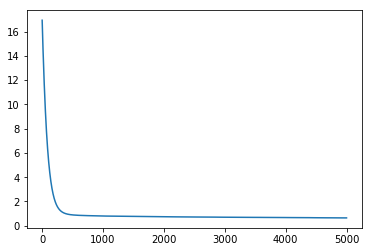

Training error 1: 421.075167672
Prediction error 1: 510.544461904
Training error 2: 0.848436931679
Prediction error 2: 1.05621217743


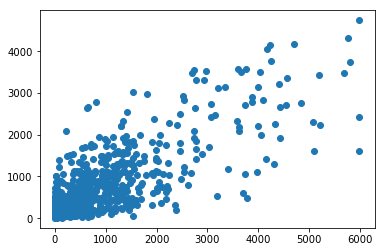

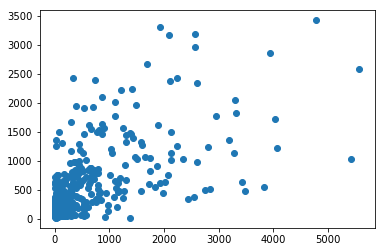

In [11]:
train_model(model_l2_6_layers, epochs=5000)
model_pred(model_l2_6_layers)

Error is less than one standard deviation, but there is still room to improve.
Next step is to try cleaning/imputing data more.

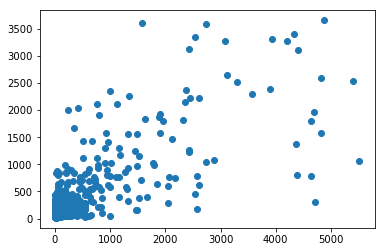

In [14]:
Y_hat_norm_test = model_l2_6_layers.predict(X_norm_test)
Y_hat_test = inverse_norm(Y_hat_norm_test,Y_mean,Y_std)
Y_test = inverse_norm(Y_norm_test,Y_mean,Y_std)
plt.scatter(Y_test, Y_hat_test)
plt.show()

In [15]:
print('Prediction error 1: ' + str(root_mean_sq_error(Y_hat_test,Y_test)))
print('Prediction error 2: ' + str(abs_mean_error(Y_hat_test,Y_test)))

Prediction error 1: 537.567825941
Prediction error 2: 0.973667018928
